# Thực hành về nhà: Mô hình sinh DCGAN

In [1]:
!nvidia-smi
!pip install torchsummary
#from google.colab import drive
#drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

Tue Sep 24 15:08:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
width = 28
height = 28
channels = 1

<H2>1. Load dữ liệu MNIST</H2>


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5639821.74it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1016375.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9572380.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2823555.47it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



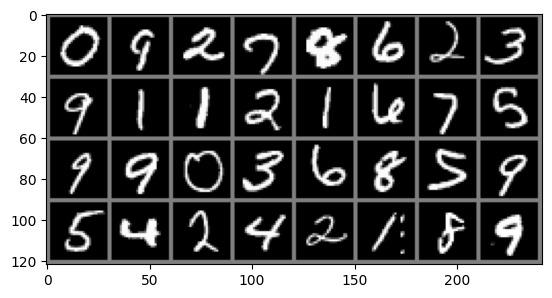

    0     9     2     7     8     6     2     3     9     1     1     2     1     6     7     5     9     9     0     3     6     8     5     9     5     4     2     4     2     1     8     9


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

<H2>2. Generator</H2>

Lập trình mạng generator.
    
    + Đầu vào là vector ngẫu nhiên 100 chiều.
    + Đầu ra là một ảnh fake với giá trị pixel trong khoảng [-1, 1].

Các thông số của mạng như sau

- Dense(7*7*128, kernel_initializer='glorot_normal',input_shape=(inidim,)))
- LeakyReLU(0.2))
- Reshape( [7, 7, 128])
- UpSampling2D(size=(2, 2))
- Conv2D(64, (5, 5), padding='same', kernel_initializer='glorot_uniform')
- LeakyReLU(0.2)
- UpSampling2D(size=(2, 2))
- Conv2D(1, (5, 5), padding='same', kernel_initializer='glorot_uniform'))
- Activation('tanh')



In [5]:
import torch
import torch.nn as nn
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, in_dim=100):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_dim, 128 * 7 * 7, bias=False),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128, 7, 7)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=5, padding='same', bias=False),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, kernel_size=5, padding='same', bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return x

G = Generator().to(device)

summary(G, (100,), batch_size=-1, device=str(device))
print("_____________________ Generator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         627,200
         LeakyReLU-2                 [-1, 6272]               0
         Unflatten-3            [-1, 128, 7, 7]               0
          Upsample-4          [-1, 128, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]         204,800
         LeakyReLU-6           [-1, 64, 14, 14]               0
          Upsample-7           [-1, 64, 28, 28]               0
            Conv2d-8            [-1, 1, 28, 28]           1,600
              Tanh-9            [-1, 1, 28, 28]               0
Total params: 833,600
Trainable params: 833,600
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.92
Params size (MB): 3.18
Estimated Total Size (MB): 4.10
-------------------------------------------

<H2>4. Discriminator</H2>

Khai báo mạng discriminator

    + Đầu vào là một ảnh 28x28
    + Đầu ra là một xác suất cho ta biết ảnh đấy là real hay fake với giá trị trong miền [0, 1]

Thông số của mạng như sau:

-  Conv2D(64, (5, 5), strides=(2, 2), padding= 'same',input_shape=shp)
-  LeakyReLU(0.2)
-  Dropout(dropout_rate)
-  Conv2D(128, (5, 5), strides=(2, 2), padding = 'same')
-  LeakyReLU(0.2)
-  Dropout(dropout_rate)
-  Flatten()
-  Dense(1,activation='sigmoid')

In [6]:
import torch
import torch.nn as nn
from torchsummary import summary

class Discriminator(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),  # Thay padding='same' bằng padding=2
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # Thay padding='same' bằng padding=2
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),  # Kích thước sau khi Flatten
            nn.Sigmoid()  # Đầu ra từ 0 đến 1
        )

    def forward(self, x):
        x = self.model(x)  # Tích hợp các lớp
        return x

# Khởi tạo Discriminator
D = Discriminator().to(device)

# Sử dụng 'cuda' hoặc 'cpu' để thay thế cho device
summary(D, (1, 28, 28), batch_size=-1, device=str(device))
print("____________________ Discriminator Created____________________")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
         LeakyReLU-2           [-1, 64, 14, 14]               0
           Dropout-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]         204,928
         LeakyReLU-5            [-1, 128, 7, 7]               0
           Dropout-6            [-1, 128, 7, 7]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                    [-1, 1]           6,273
           Sigmoid-9                    [-1, 1]               0
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.81
Estimated Total Size (MB): 1.29
-------------------------------------------

<h2>5. GAN model</h2>

Chúng ta ghép hai mạng vào với nhau mang generator trước, mạng disciminator sau

Lập trình hàm để ghép mạng

In [7]:
def gans(G, D, z):
  fake = G(z)
  predictions = D(fake)

  return predictions, fake


lr = 0.0002
betas = (0.5, 0.999)
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=betas)

criterion = nn.BCELoss()

epochs = 100
batch_size = 64

losses_G = []
losses_D = []
samples = []

In [8]:
for epoch in range(epochs):
    for (i, (imgs, _)) in enumerate(trainloader, start=1):
        # Adversarial ground truths
        valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_labels = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(torch.cuda.FloatTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise
        z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        pred_fake, gen_imgs = gans(G, D, z)

        g_loss = criterion(pred_fake, valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        real_loss = criterion(D(real_imgs), valid)

        # Discriminator
        fake_loss = criterion(D(gen_imgs.detach()), fake_labels)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if epoch % 10 == 0 and i == len(trainloader):
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
            )

            losses_G.append(g_loss.item())
            losses_D.append(d_loss.item())
            samples.append(gen_imgs)

# Sau khi huấn luyện, bạn có thể sử dụng losses_G và losses_D để phân tích


/tmp/ipykernel_36/2594333541.py:4: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /usr/local/src/pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)


[Epoch 0/100] [Batch 1875/1875] [D loss: 0.000013] [G loss: 10.765043]
[Epoch 10/100] [Batch 1875/1875] [D loss: 0.605798] [G loss: 1.265152]
[Epoch 20/100] [Batch 1875/1875] [D loss: 0.531031] [G loss: 0.965020]
[Epoch 30/100] [Batch 1875/1875] [D loss: 0.423781] [G loss: 1.229896]
[Epoch 40/100] [Batch 1875/1875] [D loss: 0.575717] [G loss: 1.059917]
[Epoch 50/100] [Batch 1875/1875] [D loss: 0.583235] [G loss: 1.250475]
[Epoch 60/100] [Batch 1875/1875] [D loss: 0.598316] [G loss: 1.274518]
[Epoch 70/100] [Batch 1875/1875] [D loss: 0.496284] [G loss: 1.251687]
[Epoch 80/100] [Batch 1875/1875] [D loss: 0.570182] [G loss: 1.473257]
[Epoch 90/100] [Batch 1875/1875] [D loss: 0.524588] [G loss: 1.434628]


### Vẽ đồ thị loss khi huấn luyện

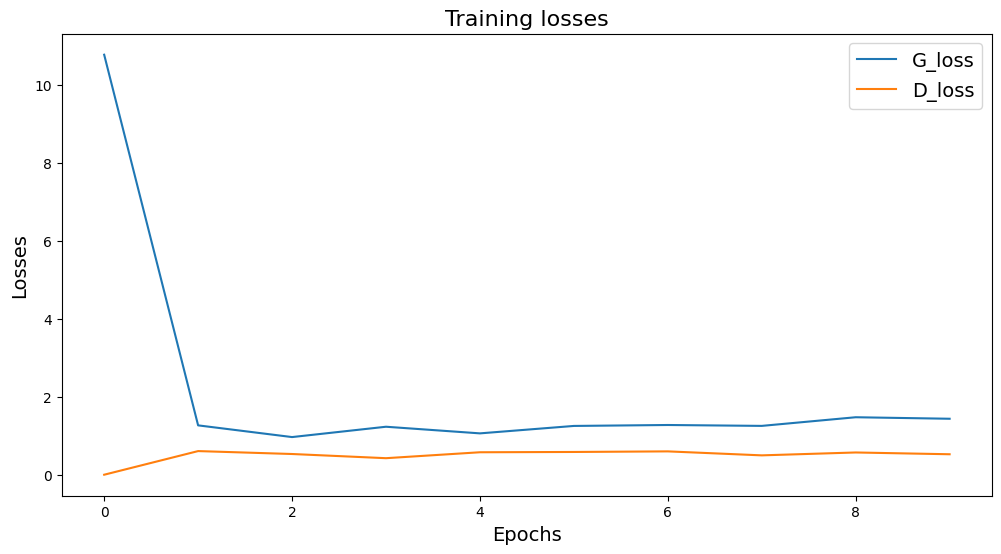

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(losses_G)//10*10)), losses_G, label="G_loss")
plt.plot(list(range(len(losses_D)//10*10)), losses_D, label="D_loss")
plt.title("Training losses", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Losses", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.show()

### Trực quan dữ liệu sinh ra thử mạng học được

    ____________________ Step = 0 ____________________


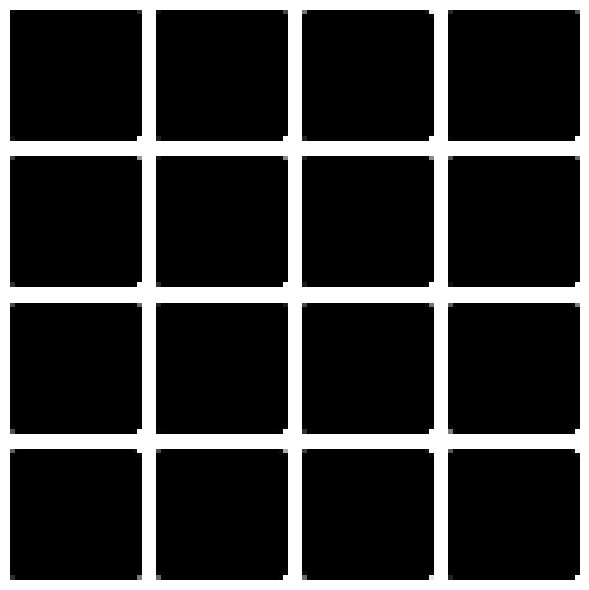

In [12]:
i = 0
for i in range(0, len(samples), 10):
    images = samples[i].data.cpu().numpy()
    print("    ____________________ Step = %d ____________________" % i)
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n")